In [1]:
#!pip install torch==2.0.0+cu117 torchvision==0.15.1+cu117 torchaudio==2.0.1 --index-url https://download.pytorch.org/whl/cu117

In [2]:
# !pip install matplotlib
# !pip install numpy
# !pip install pandas
# !pip install scikit-learn

## I. MNIST Data

### Exercice 1 : Loading Data

In [3]:
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

from copy import deepcopy

import random
import numpy as np
import matplotlib.pyplot as plt

1)Create a function iid_split. This function should take a dataset, nb_nodes, n_samples_per_node, batch_size, and shuffle as parameters. The goal is to divide the dataset into nb_nodes subsets (i.i.d.) and load each subset using PyTorch's DataLoader with the specified batch_size and shuffle, and then return a list of these DataLoaders.

Steps:
Load Data: Use DataLoader to load n_samples_per_node from the dataset with shuffle.  
Split Data: Divide the loaded data into nb_nodes i.i.d subsets, create a DataLoader for each, and append it to a list.   
Return List: Return the list of DataLoaders created.   

In [4]:
def iid_split(dataset, nb_nodes, n_samples_per_node, batch_size, shuffle=True):
    data_loaders = []

    if len(dataset) < nb_nodes * n_samples_per_node:
        raise ValueError("Dataset is too small")

    indices = random.sample(range(len(dataset)), nb_nodes * n_samples_per_node)

    for i in range(nb_nodes):
        start_idx = i * n_samples_per_node
        end_idx = (i + 1) * n_samples_per_node
        subset_indices = indices[start_idx:end_idx]

        subset = Subset(dataset, subset_indices)
        loader = DataLoader(subset, batch_size=batch_size, shuffle=shuffle)
        data_loaders.append(loader)

    return data_loaders


2) Create a function non_iid_split, designed to divide a dataset non-i.i.d. It will receive parameters: dataset, nb_nodes, n_samples_per_node, batch_size, shuffle, and shuffle_digits.

Steps:
Arrange Digits: Optionally shuffle digits and fairly split them among nb_nodes.  
Load Data: Utilize DataLoader to load nb_nodes*n_samples_per_node samples, considering the shuffle parameter.   
Split Data and Return: Create DataLoaders for each node containing samples with corresponding digits and append them to a list.   

In [5]:
def non_iid_split(dataset, nb_nodes, n_samples_per_node, batch_size, shuffle, shuffle_digits=False):
    assert(nb_nodes>0 and nb_nodes<=10)

    digits=torch.arange(10) if shuffle_digits==False else torch.randperm(10, generator=torch.Generator().manual_seed(0))

    digits_per_node = torch.chunk(digits, nb_nodes)

    loader = torch.utils.data.DataLoader(dataset, batch_size=nb_nodes*n_samples_per_node, shuffle=shuffle)
    dataiter = iter(loader)
    images_train_mnist, labels_train_mnist = next(dataiter)

    data_splitted=list()
    for i in range(nb_nodes):

        indices = [idx for idx, label in enumerate(labels_train_mnist) if label.item() in digits_per_node[i]]

        subset = Subset(dataset, indices)
        node_loader = DataLoader(subset, batch_size=batch_size, shuffle=shuffle)

        data_splitted.append(node_loader)

    return data_splitted

3) Create a function get_MNIST, that fetches the MNIST dataset and utilizes either iid_split or non_iid_split to return train and test DataLoaders. The parameters are type ("iid" or "non_iid"), n_samples_train, n_samples_test, n_clients, batch_size, and shuffle.

Steps:
Load MNIST Dataset: Utilize the MNIST dataset from PyTorch datasets for both train and test.  
Apply Split Function: Depending on the type parameter, apply either iid_split or non_iid_split to the loaded datasets.   
Return DataLoaders: Return the created train and test DataLoaders lists.  


In [6]:
def get_MNIST(type="iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True):

    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,))])

    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    if type == "iid":
        train_loaders = iid_split(train_dataset, n_clients, n_samples_train, batch_size, shuffle)
        test_loaders = iid_split(test_dataset, n_clients, n_samples_test, batch_size, shuffle)
    elif type == "non_iid":
        train_loaders = non_iid_split(train_dataset, n_clients, n_samples_train, batch_size, shuffle)
        test_loaders = non_iid_split(test_dataset, n_clients, n_samples_test, batch_size, shuffle)
    else:
        raise ValueError("Invalid type! Choose either 'iid' or 'non_iid'")

    return train_loaders, test_loaders


4) Use get_MNIST to get mnist_iid_train and mnist_iid_test dataloaders.

In [7]:
mnist_iid_train, mnist_iid_test = get_MNIST(type="iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True)

5) Giving the following function plot_samples for iid data. Plot image samples of client 1, 2 and 3.

In [8]:
def plot_samples(data, channel:int, title=None, plot_name="", n_examples =20):

    n_rows = int(n_examples / 5)
    plt.figure(figsize=(1* n_rows, 1*n_rows))
    if title: plt.suptitle(title)
    X, y= data
    for idx in range(n_examples):

        ax = plt.subplot(n_rows, 5, idx + 1)

        image = 255 - X[idx, channel].view((28,28))
        ax.imshow(image, cmap='gist_gray')
        ax.axis("off")

    if plot_name!="":plt.savefig(f"plots/"+plot_name+".png")

    plt.tight_layout()

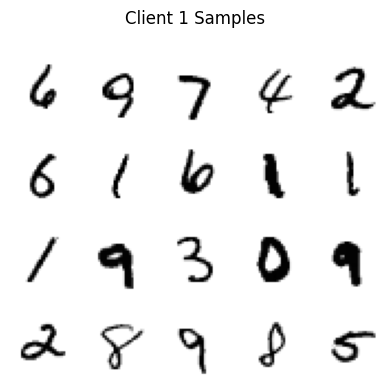

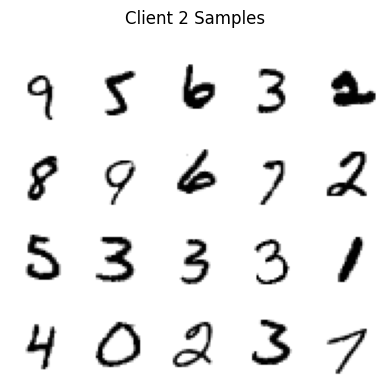

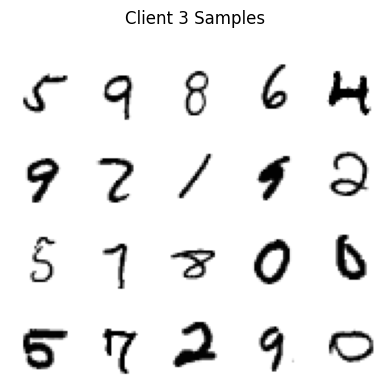

In [9]:
for i, client_loader in enumerate(mnist_iid_train[:3]):

    images, labels = next(iter(client_loader))

    plot_samples((images, labels), channel=0, title=f"Client {i+1} Samples", n_examples=20)

plt.show()


6) Plot samples this time for non_iid data for 3 clients.

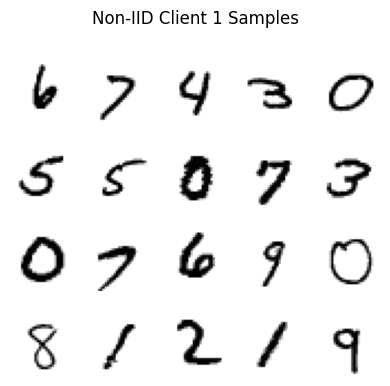

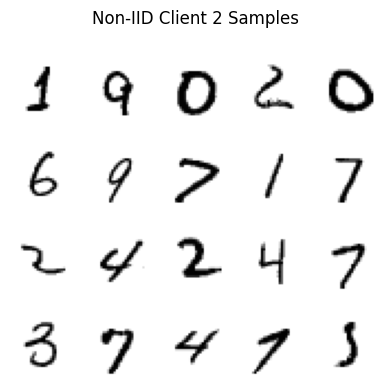

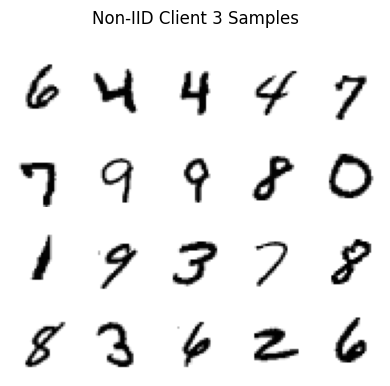

In [10]:
mnist_non_iid_train, mnist_non_iid_test = get_MNIST(type="non_iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True)

for i, client_loader in enumerate(mnist_non_iid_train[:3]):
    images, labels = next(iter(client_loader))

    plot_samples((images, labels), channel=0, title=f"Non-IID Client {i+1} Samples", n_examples=20)

plt.show()

### Exercice 2 : FedAvg and FedProx Implementation

Here is a simple CNN.

In [11]:
class CNN(nn.Module):

    """ConvNet -> Max_Pool -> RELU -> ConvNet ->
    Max_Pool -> RELU -> FC -> RELU -> FC -> SOFTMAX"""
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

model_0 = CNN()

1) Create a function difference_models_norm_2(model_1, model_2) which take two models, get models parameters and returns the sum of the square differences of models parameters.





In [12]:
def difference_models_norm_2(model_1, model_2):
    """Return the norm 2 difference between the two model parameters
    """
    diff = 0
    for (param_1, param_2) in zip(model_1.parameters(), model_2.parameters()):
        diff += torch.sum((param_1 - param_2) ** 2)

    return diff.item()

Here is the function to perform one epoch of training data.

In [13]:
def train_step(model, model_0, mu:int, optimizer, train_data, loss_f):
    """Train `model` on one epoch of `train_data`"""

    total_loss=0

    for idx, (features,labels) in enumerate(train_data):

        optimizer.zero_grad()

        predictions= model(features)

        loss=loss_f(predictions,labels)
        loss+=mu/2*difference_models_norm_2(model,model_0)
        total_loss+=loss

        loss.backward()
        optimizer.step()

    return total_loss/(idx+1)

2) Create a function local_learning which perform a local training of a model sent. We need to precise number of epochs needed to be performed locally. Use previous function defined.

Return the local_loss compute during local training.

In [14]:
def local_learning(model, mu:float, optimizer, train_data, epochs:int, loss_f):
    model_0 = copy.deepcopy(model)

    local_loss = None

    for epoch in range(epochs):
        local_loss = train_step(model, model_0, mu, optimizer, train_data, loss_f)

    return float(local_loss.detach().numpy())


We defined 4 others usefull functions :
- loss_classifier :
- loss_dataset :
- accuracy_dataset :
- set_to_zero_model_weights :

Take time to read it.

In [15]:
def loss_classifier(predictions,labels):

    m = nn.LogSoftmax(dim=1)
    loss = nn.NLLLoss(reduction="mean")

    return loss(m(predictions) ,labels.view(-1))


def loss_dataset(model, dataset, loss_f):
    """Compute the loss of `model` on `dataset`"""
    loss=0

    for idx,(features,labels) in enumerate(dataset):

        predictions= model(features)
        loss+=loss_f(predictions,labels)

    loss/=idx+1
    return loss


def accuracy_dataset(model, dataset):
    """Compute the accuracy of `model` on `dataset`"""

    correct=0

    for features,labels in iter(dataset):

        predictions= model(features)

        _,predicted=predictions.max(1,keepdim=True)

        correct+=torch.sum(predicted.view(-1,1)==labels.view(-1, 1)).item()

    accuracy = 100*correct/len(dataset.dataset)

    return accuracy

def set_to_zero_model_weights(model):
    """Set all the parameters of a model to 0"""

    for layer_weigths in model.parameters():
        layer_weigths.data.sub_(layer_weigths.data)

3) Defined a function average_models, which as it is written average parameters of a list of models to create a new model.


In [16]:
def average_models(model, clients_models_hist:list , weights:list):


    """Creates the new model of a given iteration with the models of the other
    clients"""

    new_model=deepcopy(model)
    set_to_zero_model_weights(new_model)

    for k,client_hist in enumerate(clients_models_hist):

        for idx, layer_weights in enumerate(new_model.parameters()):

            contribution=client_hist[idx].data*weights[k]
            layer_weights.data.add_(contribution)

    return new_model

4) We will now code a function to perform FedProx.

In [17]:
def FedProx(model, training_sets:list, n_iter:int, testing_sets:list, mu=0,
    file_name="test", epochs=5, lr=10**-2, decay=1):
    """ all the clients are considered in this implementation of FedProx
    Parameters:
        - `model`: common structure used by the clients and the server
        - `training_sets`: list of the training sets. At each index is the
            training set of client "index"
        - `n_iter`: number of iterations the server will run
        - `testing_set`: list of the testing sets. If [], then the testing
            accuracy is not computed
        - `mu`: regularization term for FedProx. mu=0 for FedAvg
        - `epochs`: number of epochs each client is running
        - `lr`: learning rate of the optimizer
        - `decay`: to change the learning rate at each iteration

    returns :
        - `model`: the final global model
    """

    loss_f=loss_classifier

    K=len(training_sets)
    n_samples=sum([len(db.dataset) for db in training_sets])
    weights=([len(db.dataset)/n_samples for db in training_sets])
    print("Clients' weights:",weights)


    loss_hist=[[float(loss_dataset(model, dl, loss_f).detach())
        for dl in training_sets]]
    acc_hist=[[accuracy_dataset(model, dl) for dl in testing_sets]]
    server_hist=[[tens_param.detach().numpy()
        for tens_param in list(model.parameters())]]
    models_hist = []


    server_loss=sum([weights[i]*loss_hist[-1][i] for i in range(len(weights))])
    server_acc=sum([weights[i]*acc_hist[-1][i] for i in range(len(weights))])
    print(f'====> i: 0 Loss: {server_loss} Server Test Accuracy: {server_acc}')

    for i in range(n_iter):

        clients_params=[]
        clients_models=[]
        clients_losses=[]

        for k in range(K):

            local_model= deepcopy(model)
            # Define optimizer for local_model, don't forget the learning rate !
            local_optimizer= optim.SGD(local_model.parameters(), lr=lr)
            # compute local_loss by performing learning steps on the current model
            local_loss= local_learning(local_model, mu, local_optimizer, training_sets[k], epochs, loss_f)

            clients_losses.append(local_loss)

            #GET THE PARAMETER TENSORS OF THE MODEL
            list_params=list(local_model.parameters())
            list_params=[tens_param.detach() for tens_param in list_params]
            clients_params.append(list_params)
            clients_models.append(deepcopy(local_model))


        model = average_models(model, clients_params, weights)
        models_hist.append(clients_models)

        #COMPUTE THE LOSS/ACCURACY OF THE DIFFERENT CLIENTS WITH THE NEW MODEL
        loss_hist+=[[float(loss_dataset(model, dl, loss_f).detach())
            for dl in training_sets]]
        acc_hist+=[[accuracy_dataset(model, dl) for dl in testing_sets]]

        server_loss=sum([weights[i]*loss_hist[-1][i] for i in range(len(weights))])
        server_acc=sum([weights[i]*acc_hist[-1][i] for i in range(len(weights))])

        print(f'====> i: {i+1} Loss: {server_loss} Server Test Accuracy: {server_acc}')


        server_hist.append([tens_param.detach().cpu().numpy()
            for tens_param in list(model.parameters())])

        #DECREASING THE LEARNING RATE AT EACH SERVER ITERATION
        lr*=decay

    return model, loss_hist, acc_hist

###  Exercice 3 : iid data

#### Fed training with FedAvg

1) With FedProx compute a FedAvg on iid data.

In [18]:
import copy
model = CNN()

n_iter = 10

model, loss_hist, acc_hist = FedProx(
    model,
    training_sets=mnist_iid_train,
    n_iter=n_iter,
    testing_sets=mnist_iid_test,
    mu=0,
    file_name="fedavg_iid",
    epochs=5,
    lr=10**-2,
    decay=1
)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.304100275039673 Server Test Accuracy: 7.333333333333333
====> i: 1 Loss: 2.2531529267628985 Server Test Accuracy: 13.666666666666666
====> i: 2 Loss: 2.190791368484497 Server Test Accuracy: 20.0
====> i: 3 Loss: 2.084053913752238 Server Test Accuracy: 35.0
====> i: 4 Loss: 1.8578356107076008 Server Test Accuracy: 61.0
====> i: 5 Loss: 1.3897185722986856 Server Test Accuracy: 78.33333333333333
====> i: 6 Loss: 0.8766867319742838 Server Test Accuracy: 81.0
====> i: 7 Loss: 0.6167861421902974 Server Test Accuracy: 83.0
====> i: 8 Loss: 0.5017403761545817 Server Test Accuracy: 82.66666666666666
====> i: 9 Loss: 0.41483820478121436 Server Test Accuracy: 87.33333333333333
====> i: 10 Loss: 0.3621776700019836 Server Test Accuracy: 85.66666666666666


2) Define a function plot_accuracy_loss to plot accuracy and loss of performed FedAvg for the 3 different clients.

In [19]:
def plot_acc_loss(title:str, loss_hist:list, acc_hist:list):
    assert len(loss_hist) == len(acc_hist)

    n_clients = len(loss_hist[0])

    fig, axs = plt.subplots(n_clients, 2, figsize=(10, 5 * n_clients))

    for i in range(n_clients):
        # Plotting Loss
        axs[i, 0].plot(range(1, len(loss_hist) + 1), [epoch[i] for epoch in loss_hist])
        axs[i, 0].set_title(f'Client {i+1} - Loss')
        axs[i, 0].set_xlabel('Server Iterations')
        axs[i, 0].set_ylabel('Loss')

        # Plotting Accuracy
        axs[i, 1].plot(range(1, len(acc_hist) + 1), [epoch[i] for epoch in acc_hist])
        axs[i, 1].set_title(f'Client {i+1} - Accuracy')
        axs[i, 1].set_xlabel('Server Iterations')
        axs[i, 1].set_ylabel('Accuracy')

    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()


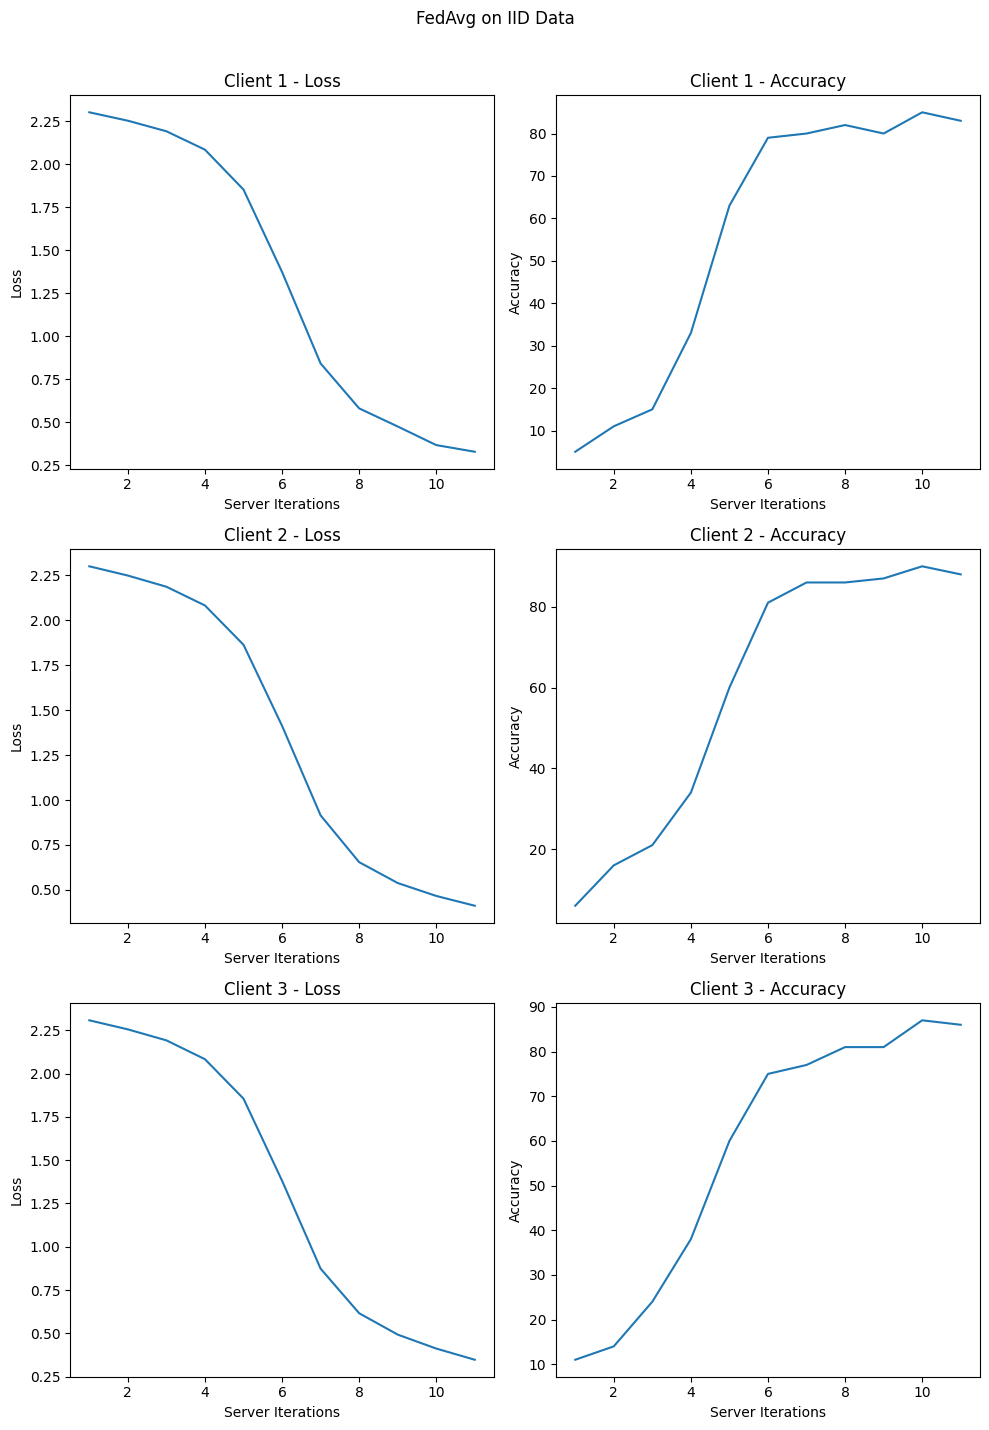

In [20]:
plot_acc_loss('FedAvg on IID Data', loss_hist, acc_hist)

#### FedPRox

3) Do the same as for 1) and 2).
You can take 2 local epochs, a learning rate of 0.1, mu = 0.3 and 10 iterations.

In [21]:
n_iter = 10

# FedAvg using FedProx with mu=0.3 on iid data
model, loss_hist, acc_hist = FedProx(
    model,
    training_sets=mnist_iid_train,
    n_iter=n_iter,
    testing_sets=mnist_iid_test,
    mu=0.3,
    file_name="fedavg_iid",
    epochs=2,
    lr=10**-1,
    decay=1
)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 0.36217766006787616 Server Test Accuracy: 85.66666666666666
====> i: 1 Loss: 1.9830531676610308 Server Test Accuracy: 44.33333333333333
====> i: 2 Loss: 0.5993984937667847 Server Test Accuracy: 83.66666666666666
====> i: 3 Loss: 0.4418256382147471 Server Test Accuracy: 83.66666666666666
====> i: 4 Loss: 0.22286097705364227 Server Test Accuracy: 89.66666666666666
====> i: 5 Loss: 0.16359775761763254 Server Test Accuracy: 90.33333333333333
====> i: 6 Loss: 0.10083860407272974 Server Test Accuracy: 90.33333333333333
====> i: 7 Loss: 0.06981812417507172 Server Test Accuracy: 91.66666666666666
====> i: 8 Loss: 0.05703844378391901 Server Test Accuracy: 92.66666666666666
====> i: 9 Loss: 0.03692452237010002 Server Test Accuracy: 92.0
====> i: 10 Loss: 0.02822627934316794 Server Test Accuracy: 92.33333333333333


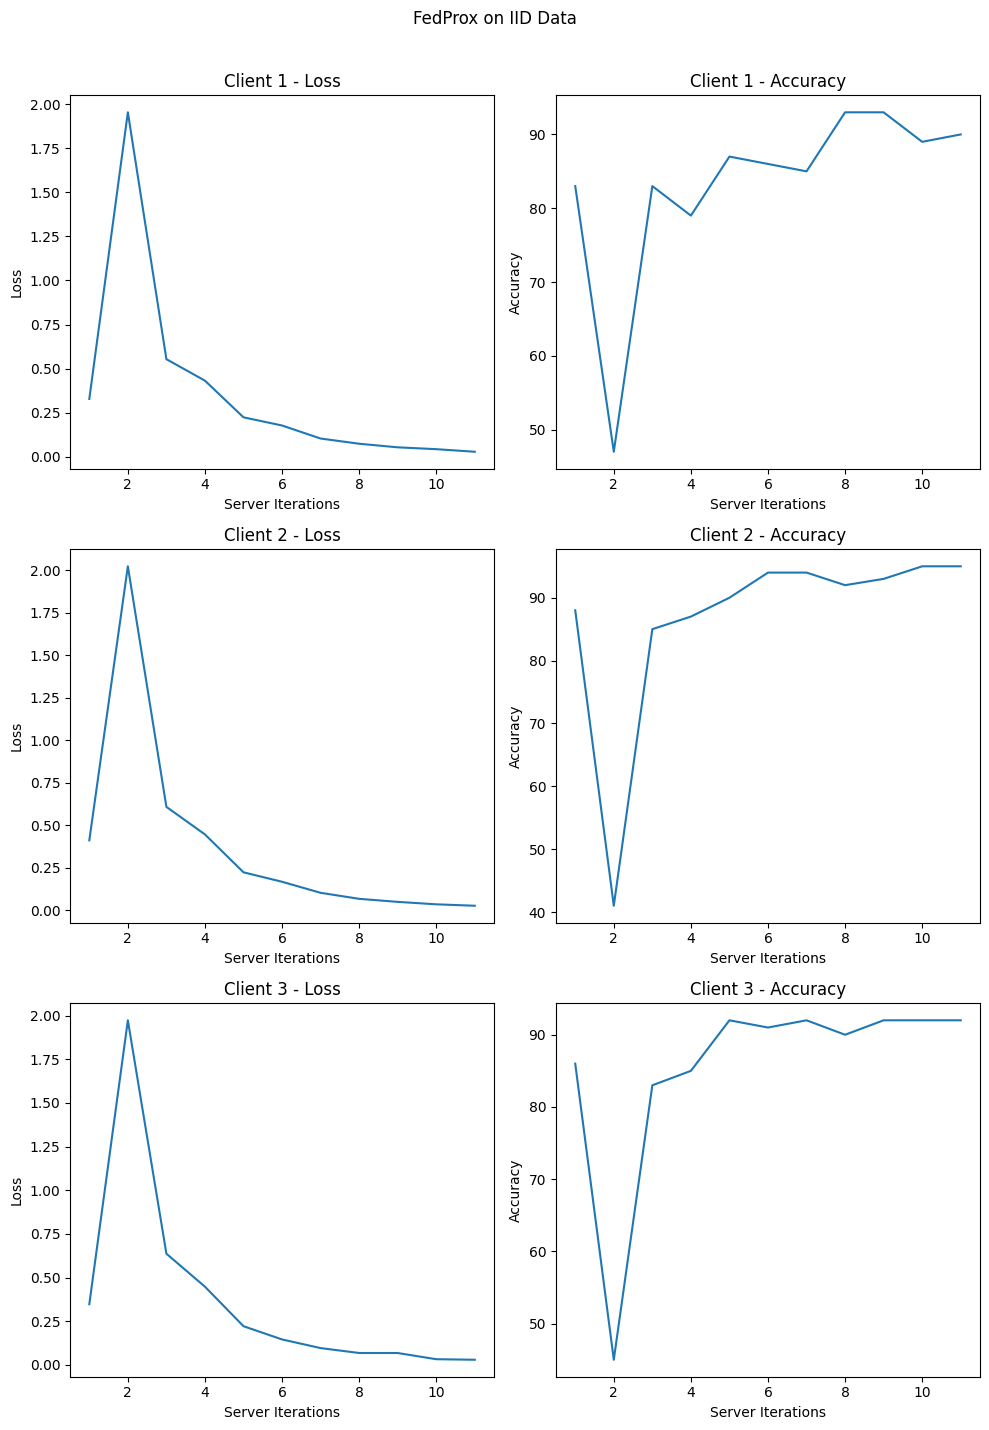

In [22]:
plot_acc_loss('FedProx on IID Data', loss_hist, acc_hist)

4) What do you observe ?

### Exercice 4 : Non iid data

1) Perform a FedAvg on data and plot accuracy and loss

In [23]:
model = CNN()
n_iter = 10

# Perform FedAvg using FedProx with mu=0 on non-iid data
model, loss_hist, acc_hist = FedProx(
    model,
    training_sets=mnist_non_iid_train,
    n_iter=n_iter,
    testing_sets=mnist_non_iid_test,
    mu=0,
    file_name="fedavg_non_iid",
    epochs=5,
    lr=10**-2,
    decay=1
)

Clients' weights: [0.3983333333333333, 0.38, 0.22166666666666668]
====> i: 0 Loss: 2.2971451040109 Server Test Accuracy: 13.58942414847315
====> i: 1 Loss: 2.2204507795969644 Server Test Accuracy: 15.119524067792952
====> i: 2 Loss: 2.0860882159074148 Server Test Accuracy: 40.892494987844
====> i: 3 Loss: 1.7709740728139876 Server Test Accuracy: 54.45673355837441
====> i: 4 Loss: 1.25842710852623 Server Test Accuracy: 60.49268549024687
====> i: 5 Loss: 0.7842944935957591 Server Test Accuracy: 72.88327612864579
====> i: 6 Loss: 0.5419658668835958 Server Test Accuracy: 80.52036972576828
====> i: 7 Loss: 0.4811109469334285 Server Test Accuracy: 80.50575419793361
====> i: 8 Loss: 0.3684373131394386 Server Test Accuracy: 83.32805269307256
====> i: 9 Loss: 0.4706629370649656 Server Test Accuracy: 78.15763196878567
====> i: 10 Loss: 0.25556601529320083 Server Test Accuracy: 88.2126800126282


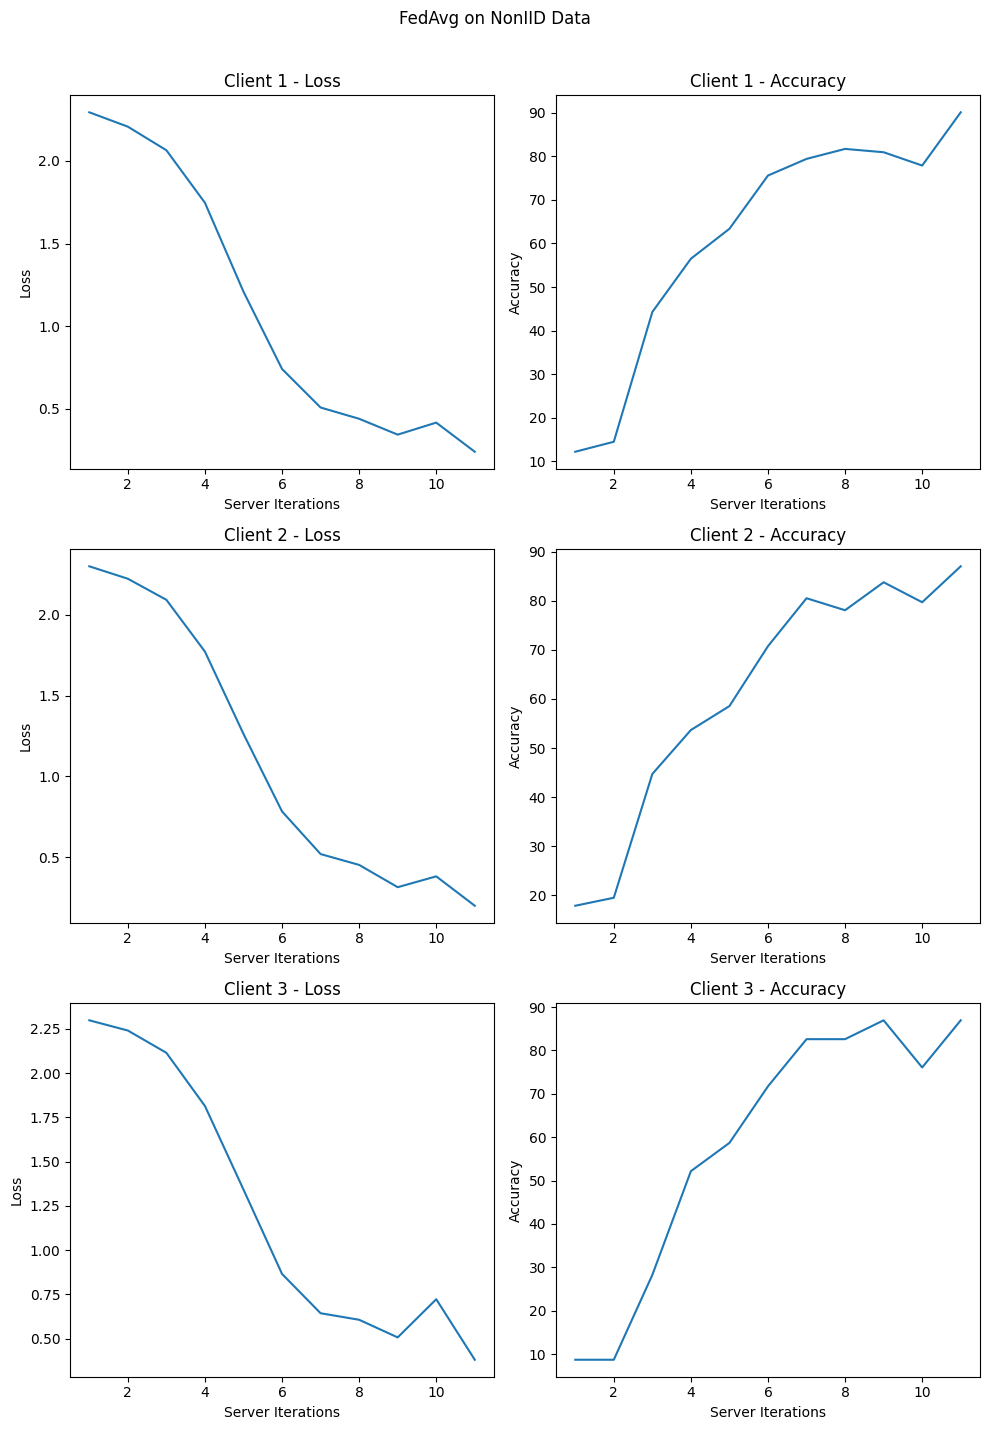

In [24]:
plot_acc_loss('FedAvg on NonIID Data', loss_hist, acc_hist)

2) Do the same for a FedProx.

In [25]:
model = CNN()
n_iter = 10

# Perform FedAvg using FedProx with mu=0 on non-iid data
model, loss_hist, acc_hist = FedProx(
    model,
    training_sets=mnist_non_iid_train,
    n_iter=n_iter,
    testing_sets=mnist_non_iid_test,
    mu=0.3,
    file_name="fedavg_non_iid",
    epochs=2,
    lr=10**-1,
    decay=1
)

Clients' weights: [0.3983333333333333, 0.38, 0.22166666666666668]
====> i: 0 Loss: 2.3009120841821034 Server Test Accuracy: 11.263625239139879
====> i: 1 Loss: 1.929150908191999 Server Test Accuracy: 34.12131576178025
====> i: 2 Loss: 1.84430182437102 Server Test Accuracy: 39.85402281171832
====> i: 3 Loss: 1.0963359795014065 Server Test Accuracy: 52.51983680474043
====> i: 4 Loss: 0.2794809525708358 Server Test Accuracy: 83.31830900784945
====> i: 5 Loss: 0.19990690395236016 Server Test Accuracy: 88.08154973434898
====> i: 6 Loss: 0.1480858963355422 Server Test Accuracy: 90.04685117876734
====> i: 7 Loss: 0.09802020064244668 Server Test Accuracy: 91.01061929470937
====> i: 8 Loss: 0.26291002966463567 Server Test Accuracy: 86.25712225343295
====> i: 9 Loss: 0.13293830055743455 Server Test Accuracy: 89.01812268786477
====> i: 10 Loss: 0.08112086109817028 Server Test Accuracy: 92.11526137415373


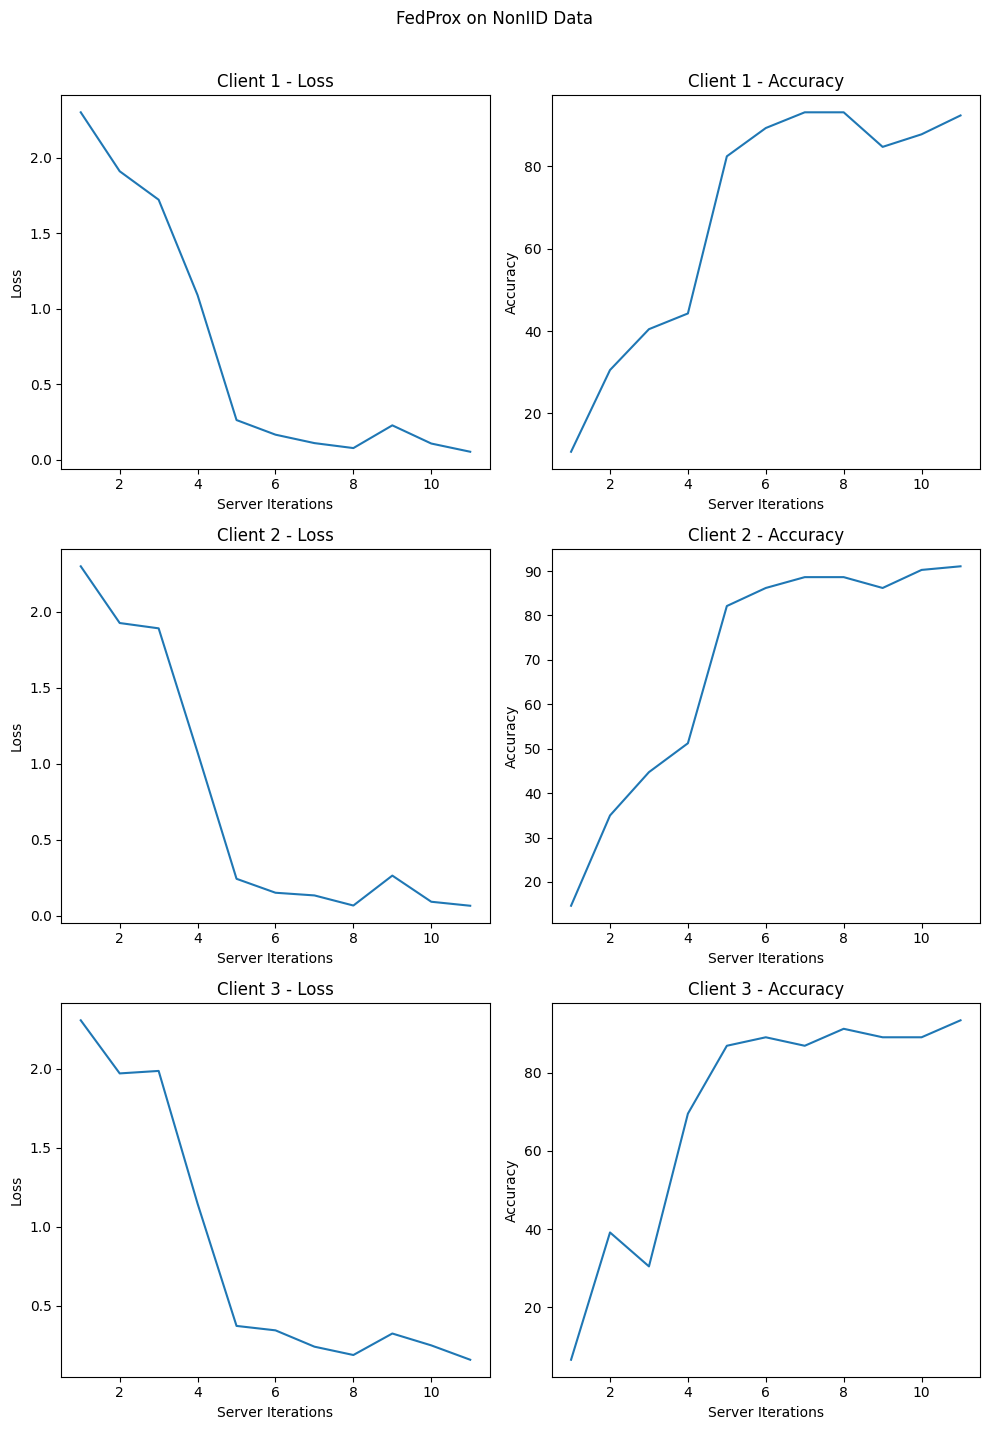

In [26]:
plot_acc_loss('FedProx on NonIID Data', loss_hist, acc_hist)

2) What do you observe ?

## II. Medical Data

### Exercice 5 : medmnist

For medical datasets we will use medmnist package.  
Medmnist is large-scale MNIST-like collection of standardized biomedical images, including 12 datasets for 2D and 6 datasets for 3D : https://medmnist.com/

In [27]:
! pip install medmnist


Import medmnist

In [28]:
import medmnist

You can list all available datasets with this command

In [29]:
!python -m medmnist available

MedMNIST v2.2.3 @ https://github.com/MedMNIST/MedMNIST/
All available datasets:
	pathmnist
	chestmnist
	dermamnist
	octmnist
	pneumoniamnist
	retinamnist
	breastmnist
	bloodmnist
	tissuemnist
	organamnist
	organcmnist
	organsmnist
	organmnist3d
	nodulemnist3d
	adrenalmnist3d
	fracturemnist3d
	vesselmnist3d
	synapsemnist3d


We will use BloodMNIST for the following exercices. BloodMnist is a dataset with 8 categories of blood cells capture by microscope.

1. Import from medmnsit BloodMNIST

In [30]:
from medmnist import BloodMNIST

In [31]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.data import Dataset

import medmnist
from medmnist import INFO, Evaluator

2. Create a preprocessing pipeline for data, transforms it into Tensor and then normalize it with a mean of 0.5 and standard deviation of 0.5 also.

In [32]:
transform_pipeline = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

3. Create a train dataset and test dataset from data and apply previous preprocessing pipeline. You can use DataClass from pytorch to create datasets.

In [33]:
class TransformedBloodMNIST(Dataset):
    def __init__(self, split='train'):
        self.dataset = BloodMNIST(root='.', split=split, transform=transform_pipeline, download=True)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

4. Just to understand data print the 2 datasets to see differences with previous MNIST data.

Using downloaded and verified file: ./bloodmnist.npz
Using downloaded and verified file: ./bloodmnist.npz


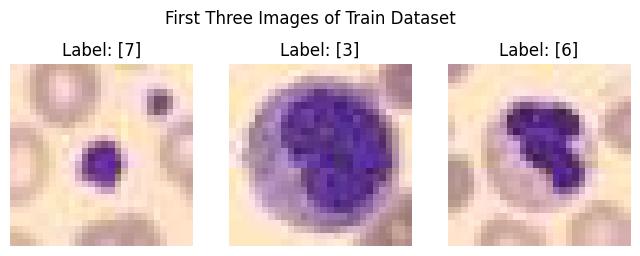

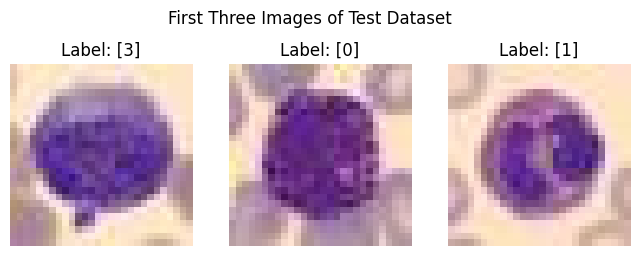

In [43]:
def plot_first_three_images(dataset, title):
    fig, axs = plt.subplots(1, 3, figsize=(8,3))

    for i in range(3):
        image, label = dataset[i]

        image = image * 0.5 + 0.5
        image = image.permute(1, 2, 0).clamp(0, 1)

        axs[i].imshow(image)
        axs[i].axis('off')
        axs[i].set_title(f'Label: {label}')

    plt.suptitle(title)
    plt.show()

train_dataset = TransformedBloodMNIST(split='train')
test_dataset = TransformedBloodMNIST(split='test')

plot_first_three_images(train_dataset, 'First Three Images of Train Dataset')
plot_first_three_images(test_dataset, 'First Three Images of Test Dataset')


5. Create a data loader for train data and test dat, you can use a batch size of 128 and shuffle data.

In [36]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


6. Modify previous functions non_iid_split, iid_split, get_MNIST and plot_samples to work with new data.  
a. non_iid_split : this time there are only 8 classes   
b. iid_split : nothing really changed  
c. get_MNIST : Like in 3. use train and test datasets with the preprocessing pipeline we defined previously.  
d. plot_samples : Make it work for this new images. Also try to print to which classes belong every images, to see later if your iid_split and non_iid_split work well.

In [37]:
#a.
def non_iid_split_8(dataset, nb_nodes, n_samples_per_node, batch_size, shuffle, shuffle_classes=False):
    assert(nb_nodes > 0 and nb_nodes <= 8)

    classes = torch.arange(8) if not shuffle_classes else torch.randperm(8, generator=torch.Generator().manual_seed(0))
    classes_per_node = torch.chunk(classes, nb_nodes)

    loader = torch.utils.data.DataLoader(dataset, batch_size=nb_nodes * n_samples_per_node, shuffle=shuffle)
    dataiter = iter(loader)
    images_train, labels_train = next(dataiter)

    data_splitted = list()
    for i in range(nb_nodes):
        indices = [idx for idx, label in enumerate(labels_train) if label.item() in classes_per_node[i]]

        subset = Subset(dataset, indices)
        node_loader = DataLoader(subset, batch_size=batch_size, shuffle=shuffle)

        data_splitted.append(node_loader)

    return data_splitted


In [38]:
#c.

def get_BloodMNIST(type="iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True):

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_dataset = BloodMNIST(root='./data', split='train', download=True, transform=transform)
    test_dataset = BloodMNIST(root='./data', split='test', download=True, transform=transform)

    if type == "iid":
        train_loaders = iid_split(train_dataset, n_clients, n_samples_train, batch_size, shuffle)
        test_loaders = iid_split(test_dataset, n_clients, n_samples_test, batch_size, shuffle)
    elif type == "non_iid":
        train_loaders = non_iid_split(train_dataset, n_clients, n_samples_train, batch_size, shuffle)
        test_loaders = non_iid_split(test_dataset, n_clients, n_samples_test, batch_size, shuffle)
    else:
        raise ValueError("Invalid type! Choose either 'iid' or 'non_iid'")

    return train_loaders, test_loaders


In [39]:
def plot_samples(data, title=None, plot_name="", n_examples=20):

    n_rows = int(n_examples / 5)
    plt.figure(figsize=(5, 1 * n_rows))
    if title: plt.suptitle(title)
    X, y = data
    for idx in range(n_examples):

        ax = plt.subplot(n_rows, 5, idx + 1)

        image = X[idx].mean(0)
        image = (image + 1) * 0.5

        ax.imshow(image, cmap='gist_gray')
        ax.set_title(f'Label: {y[idx].item()}')
        ax.axis("off")

    if plot_name != "":
        plt.savefig(f"plots/" + plot_name + ".png")

    plt.tight_layout()
    plt.show()

### Exercice 6 : Use federated learning on medical data

### IID data

1. Load train data and test data for 3 clients into IID datasets.

In [40]:
blood_mnist_iid_train, blood_mnist_iid_test = get_BloodMNIST(type="iid", n_clients=3)

Using downloaded and verified file: ./data/bloodmnist.npz
Using downloaded and verified file: ./data/bloodmnist.npz


2. plost samples with corresponding function.

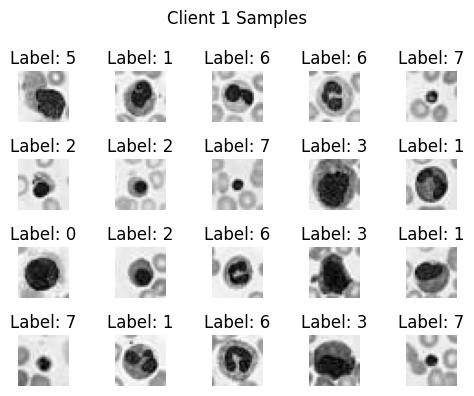

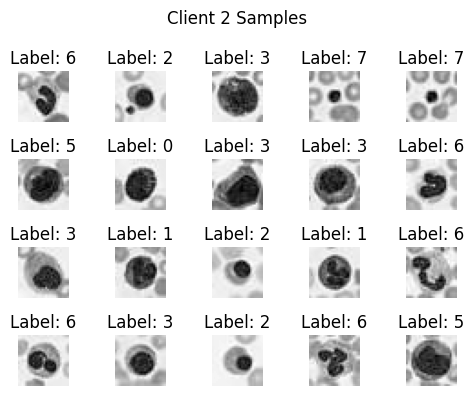

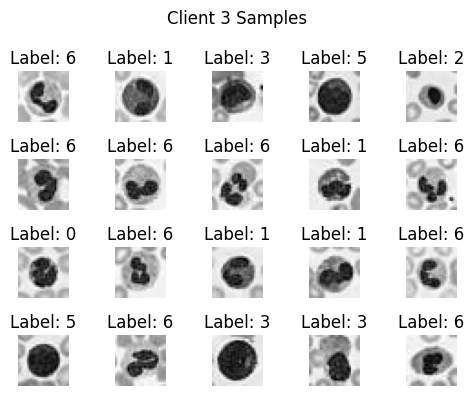

In [41]:
for i, client_loader in enumerate(blood_mnist_iid_train[:3]):
    images, labels = next(iter(client_loader))
    plot_samples((images, labels), title=f"Client {i+1} Samples", n_examples=20)

3. Design a convlution neural network to perform classification.  
You can try to adpat previous convolution network.   
Or also you can try this type of architecture :  
- A first 2D convolution layer with an output_channels of 16, a BatchNormalisation and a Relu activation   
- A second 2D conv layer identical but with a MaxPooling layer after  
- A 3rd conv layer with an output_channels of 64, a BatchNormalisation and a Relu activation again.
- A 4rd layer identical to 3rd one.  
- A 5rd layer identical but with a MaxPooling added. Don't forget to use padding to not loose informations from corners.
- Finally add dense layers to perform classification. You can add regularization layers between dropout for example.



In [42]:
class BloodNet(nn.Module):
    def __init__(self, num_classes=8):
        super(BloodNet, self).__init__()


        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(16, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)

        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.dropout = nn.Dropout


### Fed training with FedAvg

4. Perform a FedAvg with same parameters as for MNIST datasets. Use 3 clients, etc. Try to run more iterations.

### FedPRox

5. As FedAvg perform a FedProx on iid data. Keep the same µ.

### MNIST Non iid

6. Do the same process (FedAVG, FedProx, plot loss and accuracy) but this time on non iid data.

7. Is results satisfying ? Submit some way to improve results and resolve possible unstabilities. For this you can check original paper : https://arxiv.org/pdf/1812.06127.pdf